2024-07-22 18:47:52,240	INFO worker.py:1788 -- Started a local Ray instance.
/var/folders/73/wzyp1fs57lg7p28crz696s_r0000gp/T/ipykernel_73466/2054887222.py:55: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(filepath, delim_whitespace=True, comment='%', header=None)
2024-07-22 18:47:54,553	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-07-22 18:47:54,577	WARNING bayesopt_search.py:431 -- BayesOpt does not support specific sampling methods. The LogUniform sampler will be dropped.
2024-07-22 18:47:54,577	WARNING bayesopt_search.py:431 -- BayesOpt does not support specific sampling methods. The LogUniform sampler will be dropped.


Trial name,loss
train_model_0910e405,475.471
train_model_0d623c28,473.833
train_model_1672c47a,35.2678
train_model_1f046a07,475.32
train_model_20ab5ca8,475.502
train_model_2ea9b361,475.365
train_model_3b1b72cc,475.375
train_model_4f50e77a,475.095
train_model_50205c30,475.171
train_model_528752e5,475.203


(train_model pid=73517) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/hanheelee/ray_results/train_model_2024-07-22_18-47-54/train_model_76da58e8_1_beta1=0.6498,beta2=0.9941,lr=0.0007,weight_decay=0.0060_2024-07-22_18-47-54/checkpoint_000000)
(train_model pid=73517) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/hanheelee/ray_results/train_model_2024-07-22_18-47-54/train_model_76da58e8_1_beta1=0.6498,beta2=0.9941,lr=0.0007,weight_decay=0.0060_2024-07-22_18-47-54/checkpoint_000001)
(train_model pid=73517) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/hanheelee/ray_results/train_model_2024-07-22_18-47-54/train_model_76da58e8_1_beta1=0.6498,beta2=0.9941,lr=0.0007,weight_decay=0.0060_2024-07-22_18-47-54/checkpoint_000002)
(train_model pid=73517) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/hanheelee/ray_results/train_model_2024-07-22_18-47-54/train_model_76da58e8_1_bet

(train_model pid=73581) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/hanheelee/ray_results/train_model_2024-07-22_18-47-54/train_model_528a1d72_13_beta1=0.5262,beta2=0.9939,lr=0.0010,weight_decay=0.0081_2024-07-22_18-49-06/checkpoint_000027) [repeated 25x across cluster]
(train_model pid=73581) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/hanheelee/ray_results/train_model_2024-07-22_18-47-54/train_model_528a1d72_13_beta1=0.5262,beta2=0.9939,lr=0.0010,weight_decay=0.0081_2024-07-22_18-49-06/checkpoint_000038) [repeated 29x across cluster]
2024-07-22 18:49:30,798	INFO bayesopt_search.py:293 -- Skipping duplicated config: {'beta1': 0.5086766301641243, 'beta2': 0.999, 'lr': 0.001, 'weight_decay': 0.007391159499030358}.
(train_model pid=73581) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/Users/hanheelee/ray_results/train_model_2024-07-22_18-47-54/train_model_528a1d72_13_beta1=0.5262,beta2=0.9939,lr=0.0

Best hyperparameters found were:  {'lr': 0.001, 'beta1': 0.5086766201648331, 'beta2': 0.999, 'weight_decay': 0.007391186709961988}
Test MSE: 34.6824
Test RMSE: 84.6745 Pa
Relative Error: 17.87%
R^2 Score: 0.9677


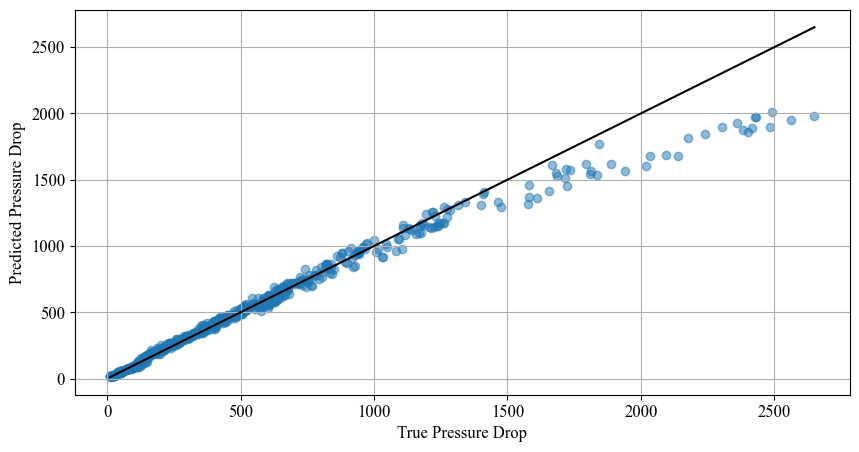

Model and scalers are saved successfully.


In [1]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import joblib
import tempfile
from ray import air, train
from ray.train import Checkpoint

import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.bayesopt import BayesOptSearch

class DelpNN(nn.Module):
    def __init__(self):
        super(DelpNN, self).__init__()
        # Define the layers of the neural network
        self.fc1 = nn.Linear(6, 512)  # Increased the number of neurons in the first layer
        self.bn1 = nn.BatchNorm1d(512)  # Batch normalization for the first layer
        self.fc2 = nn.Linear(512, 256)  # Increased the number of neurons in the second layer
        self.bn2 = nn.BatchNorm1d(256)  # Batch normalization for the second layer
        self.fc3 = nn.Linear(256, 128)  # Adjusted the number of neurons in the third layer
        self.bn3 = nn.BatchNorm1d(128)  # Batch normalization for the third layer
        self.fc4 = nn.Linear(128, 64)   # Adjusted the number of neurons in the fourth layer
        self.bn4 = nn.BatchNorm1d(64)   # Batch normalization for the fourth layer
        self.fc5 = nn.Linear(64, 1)     # Output layer with a single neuron for regression
        self.relu = nn.ReLU()           # Activation function used between layers
        self.dropout1 = nn.Dropout(p=0.3)  # Dropout with a probability of 0.3
        self.dropout2 = nn.Dropout(p=0.4)  # Dropout with a probability of 0.4
        self.dropout3 = nn.Dropout(p=0.5)  # Dropout with a probability of 0.5
        self.dropout4 = nn.Dropout(p=0.5)  # Dropout with a probability of 0.5

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))  # Pass input through the first layer, apply batch normalization and ReLU activation
        x = self.dropout1(x)                  # Apply dropout
        x = self.relu(self.bn2(self.fc2(x)))  # Pass through the second layer, apply batch normalization and ReLU activation
        x = self.dropout2(x)                  # Apply dropout
        x = self.relu(self.bn3(self.fc3(x)))  # Pass through the third layer, apply batch normalization and ReLU activation
        x = self.dropout3(x)                  # Apply dropout
        x = self.relu(self.bn4(self.fc4(x)))  # Pass through the fourth layer, apply batch normalization and ReLU activation
        x = self.dropout4(x)                  # Apply dropout
        x = self.fc5(x)                       # Output layer produces final output, no activation (linear output)
        return x

def load_and_prepare_data(filepath):
    try:
        data = pd.read_csv(filepath, delim_whitespace=True, comment='%', header=None)
        data.columns = ['HCC', 'WCC', 'LCC', 'Tamb', 'Uin', 'Q',
                        'Temperature1', 'Temperature2', 'Temperature3', 'Temperature4',
                        'Temperature5', 'Temperature6', 'Pressure1', 'Pressure2', 'Delp',
                        'Velocity1', 'Velocity2', 'Tsta', 'StackTemp2']
    except Exception as e:
        print(f"Error reading the data file: {e}")
        return None, None

    feature_labels = ['HCC', 'WCC', 'LCC', 'Tamb', 'Uin', 'Q']
    X = data[feature_labels]
    Y = data['Delp']
    return X, Y

def split_data(X, Y, test_size=0.2, random_state=42):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    return X_train, X_test, Y_train, Y_test

def preprocess_and_prepare_loaders(X_train, X_test, Y_train, Y_test, batch_size=64):
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)
    joblib.dump(scaler_X, '6_scaler_X.pkl')

    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.float32).unsqueeze(1)
    Y_test_tensor = torch.tensor(Y_test.values, dtype=torch.float32).unsqueeze(1)

    train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_model(config, checkpoint_dir=None, data_dir=None):
    model = DelpNN()
    criterion = nn.L1Loss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config["lr"],
        betas=(config["beta1"], config["beta2"]),
        eps=1e-08,
        weight_decay=config["weight_decay"],
    )
    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(os.path.join(checkpoint_dir, "checkpoint.pt"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    train_loader, test_loader = data_dir

    best_loss = float('inf')
    epochs_no_improve = 0
    num_epochs = 1000  # Fixed number of epochs
    patience = 10     # Fixed patience value

    for epoch in range(num_epochs):
        running_loss = 0.0
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = sum(criterion(model(inputs), labels).item() for inputs, labels in test_loader) / len(test_loader)

        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
                path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
                torch.save((model.state_dict(), optimizer.state_dict()), path)
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
                train.report({"loss": val_loss}, checkpoint=checkpoint)
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'Early stopping after {epoch+1} epochs')
                break

        train.report({"loss": val_loss})
    
    print('Training complete.')

def evaluate_model(model, test_loader, criterion, filename='true_vs_predicted.png'):
    model.eval()
    total_loss = 0
    total_rmse = 0
    predictions, actuals = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            outputs_np = outputs.detach().cpu().numpy()
            labels_np = labels.detach().cpu().numpy()
            rmse = mean_squared_error(labels_np, outputs_np, squared=False)
            total_rmse += rmse * labels.size(0)
            predictions.extend(outputs_np.flatten())
            actuals.extend(labels_np.flatten())

    mean_loss = total_loss / len(test_loader.dataset)
    mean_rmse = total_rmse / len(test_loader.dataset)
    relative_error = (mean_rmse / np.mean(actuals)) * 100
    r2 = r2_score(actuals, predictions)

    print(f'Test MSE: {mean_loss:.4f}')
    print(f'Test RMSE: {mean_rmse:.4f} Pa')
    print(f'Relative Error: {relative_error:.2f}%')
    print(f'R^2 Score: {r2:.4f}')

    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman']
    rcParams['font.size'] = 12
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k-', label='Ideal Line')
    plt.xlabel('True Pressure Drop')
    plt.ylabel('Predicted Pressure Drop')
    plt.grid(True)
    plt.savefig(filename, format='png', bbox_inches='tight')
    plt.show()
    
    return mean_rmse

def main():
    ray.init()

    filepath = '/Users/hanheelee/Desktop/Projects/00_ML_Fuel_Cell/Set 1.txt'
    X, Y = load_and_prepare_data(filepath)
    if X is None or Y is None:
        print("Failed to load data.")
        return

    X_train, X_test, Y_train, Y_test = split_data(X, Y)
    train_loader, test_loader = preprocess_and_prepare_loaders(X_train, X_test, Y_train, Y_test)

    data_dir = (train_loader, test_loader)

    search_space = {
        "lr": tune.loguniform(1e-5, 1e-3),
        "beta1": tune.uniform(0.5, 0.9),
        "beta2": tune.uniform(0.9, 0.999),
        "weight_decay": tune.loguniform(1e-6, 1e-2)
    }

    bayesopt = BayesOptSearch(metric="loss", mode="min")
    scheduler = ASHAScheduler()

    analysis = tune.run(
        tune.with_parameters(train_model, data_dir=data_dir),
        resources_per_trial={"cpu": 2, "gpu": 0},
        config=search_space,
        num_samples=100,
        scheduler=scheduler,
        search_alg=bayesopt,
        metric="loss",
        mode="min"
    )

    print("Best hyperparameters found were: ", analysis.get_best_config(metric="loss", mode="min"))

    best_trial = analysis.get_best_trial("loss", "min", "last")
    best_checkpoint = best_trial.checkpoint

    if best_checkpoint:
        with best_checkpoint.as_directory() as best_checkpoint_dir:
            model_state, optimizer_state = torch.load(os.path.join(best_checkpoint_dir, "checkpoint.pt"))

        best_model = DelpNN()
        best_model.load_state_dict(model_state)
        mean_rmse = evaluate_model(best_model, test_loader, nn.L1Loss())
        torch.save(best_model.state_dict(), f'Delp_{mean_rmse:.4f}.pth')
        print("Model and scalers are saved successfully.")
    else:
        print("No checkpoint found for the best trial.")

if __name__ == "__main__":
    torch.manual_seed(42)
    main()